<a href="https://colab.research.google.com/github/zxllxz2/disaster-dazzlers/blob/main/incident_join.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
credentials = {
    'region_name': 'us-east-1',
    'aws_access_key_id': 'xxx',
    'aws_secret_access_key': 'xxx',
    'aws_session_token': 'xxx'
}

In [ ]:
!pip install boto3
!pip install geopandas pyarrow

import geopandas as gd
import pyarrow.parquet as pq
import pandas as pd
import boto3, json

session = boto3.session.Session(**credentials)
s3 = session.client('s3')

## Upload census tracts to S3

In [ ]:
import os

for root,dirs,files in os.walk('/content/census_tract'):
  for file in files:
    s3.upload_file(os.path.join(root[9:],file),'wwu-incidents', file)

## Join census tract and incidents

In [7]:
df = gd.read_file('/content/census_tract/tl_2016_47_tract.shp')

In [8]:
incidents=pd.read_parquet('nfd_incidents_xd_seg.parquet')
incident_geo = gd.GeoDataFrame(
    incidents,
    geometry=gd.points_from_xy(incidents.longitude, incidents.latitude),
    crs=df.crs
)

In [9]:
jd = gd.sjoin(df, incident_geo, how='inner', op='intersects')
jd.head()

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,longitude,emdCardNumber,time_utc,time_local,response_time_sec,day_of_week,weekend_or_not,Incident_ID,Dist_to_Seg,XDSegID
47,47,021,070103,47021070103,701.03,Census Tract 701.03,G5020,S,43484202,2904,...,-86.917417,29B5,2019-07-20 14:44:22.887,2019-07-20 09:44:22.887,395.0,5,1,13986,0.102966,1.524414e+09
58,47,037,011300,47037011300,113,Census Tract 113,G5020,S,4224644,0,...,-86.774908,29D5,2021-02-27 06:36:01.060,2021-02-27 00:36:01.060,406.0,5,1,29711,20.663933,1.601569e+08
58,47,037,011300,47037011300,113,Census Tract 113,G5020,S,4224644,0,...,-86.775083,29B1,2019-01-02 01:49:13.913,2019-01-01 19:49:13.913,141.0,1,0,8209,0.508230,1.524322e+09
58,47,037,011300,47037011300,113,Census Tract 113,G5020,S,4224644,0,...,-86.775555,29B5,2020-10-16 02:51:40.283,2020-10-15 21:51:40.283,503.0,3,0,26528,0.076611,1.524396e+09
58,47,037,011300,47037011300,113,Census Tract 113,G5020,S,4224644,0,...,-86.775555,29A2V,2019-10-12 04:33:59.960,2019-10-11 23:33:59.960,705.0,4,0,16656,0.076611,1.524396e+09


<Axes: >

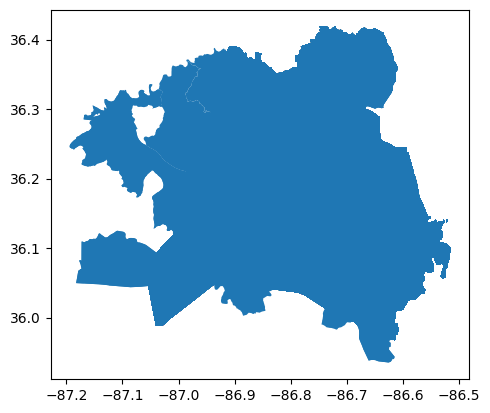

In [10]:
jd.plot()

In [11]:
jd.to_file('incident_census_join', driver="GeoJSON")

In [14]:
s3.upload_file(Bucket='wwu-incidents',Key='incident_census_join',Filename='incident_census_join')